In [1]:
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from dataload import TrainDataset,TestDataset

In [9]:
#################################################
# timestep = 1  # 时间步长，就是利用多少时间窗口
batch_size = 128 # 批次大小
input_dim = 3
hidden_dim = 24  # 隐层大小
output_dim = 1  # 由于是分类任务，最终输出层大小为1
num_layers = 3  # LSTM的层数
epochs = 100
best_loss = 10
train_ratio = 0.8  # 80% 用于训练，20% 用于验证
eval_ratio = 0.2
kernelsize = 31


device = torch.device('cpu')
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_name = 'LSTM_attention'
save_path = './{}.pth'.format(model_name)

###################################
# 数据集：传入数据地址，模型类型
dataset = TrainDataset('train_data')
# 计算划分的数量
# train_size = int(len(dataset) * train_ratio)
# eval_size = int(len(dataset) -train_size)

# 划分数据集
# train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# 创建数据加载器
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)



class LSTM_channel_attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, ratio=16):
        super(LSTM_channel_attention, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小
        self.num_layers = num_layers  # LSTM层数

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.5)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2 // ratio),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2 // ratio, hidden_dim * 2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, query):
        b, length, dim = query.size()
        output, (h_n, c_n) = self.lstm(query)  # b,len,hidden*2
        output = self.tanh(output)
        output = output.transpose(1, 2)  # b,hidden*2,length

        avg_pool = self.avg_pool(output).view([b, self.hidden_dim * 2])  # b,hidden*2
        max_pool = self.max_pool(output).view([b, self.hidden_dim * 2])  # b,hidden*2

        avg_out = self.fc(avg_pool).view([b, self.hidden_dim * 2, 1])
        max_out = self.fc(max_pool).view([b, self.hidden_dim * 2, 1])
        out = avg_out + max_out
        output_weight = self.sigmoid(output)

        output = output * output_weight
        output = output.transpose(1, 2)#（b,len,hidden*2）
        # output = self.fc1(output)  #（b,len,1）
        # output =output.squeeze()
        return output


class LSTM_spacial_attention(nn.Module):
    def __init__(self,hidden_dim, kernel_size=kernelsize):
        super(LSTM_spacial_attention, self).__init__()
        self.hidden_dim = hidden_dim  # 隐层大小

        padding = int((kernel_size-1)/2)
        self.conv = nn.Conv1d(2, 1, kernel_size,1, padding, bias=False)

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, query):
        b, length, dim = query.size()
        query = query.transpose(1,2) #b,dim,length

        max_pool,_ = torch.max(query, dim=1, keepdim=True)
        mean_pool = torch.mean(query, dim=1, keepdim=True)
        pool_out = torch.cat([max_pool, mean_pool], dim=1)
        out = self.conv(pool_out)
        output_weight = self.sigmoid(out)

        output = query * output_weight
        output = output.transpose(1, 2)
        output = self.fc1(output)
        # output =output.squeeze()
        return output


class LSTM_attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM_attention, self).__init__()
        self.channel_att = LSTM_channel_attention(input_dim, hidden_dim, num_layers, output_dim)
        self.spacial_att = LSTM_spacial_attention(hidden_dim)
        self.batchnormal = nn.BatchNorm1d(hidden_dim*2)

    def forward(self, x):
        output = self.channel_att(x)
        output = output.transpose(1, 2)
        output = self.batchnormal(output)
        output = output.transpose(1, 2)

        output = self.spacial_att(output)
        output =output.squeeze()
        return output



model = LSTM_attention(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络

model.to(device)  # 模型放到gpu中
loss_function = nn.CrossEntropyLoss()  # 定义损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# print(model)

训练部分（不用run）

In [22]:

#######################################################
for epoch in range(epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_dataloader)  # 使用tqdm形成trainbar
    for data in train_bar:
        x_train, y_train = data  # 解包迭代器中的X和Y（数据和label）
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        y_train_pred = model(x_train)
        # print("y_train_pred.shape:", y_train_pred.shape)
        # print("y_train.shape", y_train.shape)
        loss = loss_function(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 running_loss)

    # # 模型验证
    # model.eval()
    # eval_loss = 0

    # with torch.no_grad():
    #     eval_bar = tqdm(eval_dataloader)
    #     for data in eval_bar:
    #         x_eval, y_eval = data
    #         x_eval = x_eval.to(device)
    #         y_eval = y_eval.to(device)
    #         y_eval_pred = model(x_eval, x_eval, x_eval)
    #         eval_loss = loss_function(y_eval_pred, y_eval[:, :, np.newaxis])
    #         # scheduler.step(eval_loss)

torch.save(model.state_dict(), save_path)
print('Finished Training')

  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

测试集测试（不用run）

In [ ]:
from datetime import datetime
from sklearn.metrics import roc_curve,auc
model = LSTM_attention(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络
model.load_state_dict(torch.load('/home/wj/fakenet/cascadia/bilstm_attention.pth'))
model.to(device)
model.eval()
time_array = pd.read_csv('train_data/0001.2023.242.055104.csv',skiprows=1,header=None).iloc[:,0].values
time = [datetime.strptime(date,'%Y-%m-%d') for date in time_array]

dataset = TrainDataset('/home/wj/fakenet/cascadia/train_data_xiaoyu6')
eval_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
i=5
model.eval()
with torch.no_grad():
# for feature, labels in train_dataloader:
    for feature, labels in eval_dataloader:
        feature = feature.to(device)
        labels = labels.to(device)
        predictions = model(feature)
        # predictions = predictions.squeeze(-1)
        # print(predictions)
        predicted_classes = predictions >0.99


        plt.subplot(511)
        plt.scatter(time,(feature[i,:,2]).cpu(),s=1)
        plt.ylabel("Up")
        plt.xticks(())
        ax = plt.gca()

        plt.subplot(512)
        plt.scatter(time,(feature[i,:,1]).cpu(),s=1)
        plt.ylabel("East")
        plt.xticks(())

        plt.subplot(513)
        plt.scatter(time,feature[i,:,0].cpu(),s=1)
        plt.ylabel("North")
        plt.xticks(())

        plt.subplot(514)
        plt.plot(time,(labels[i,:]).cpu(),c='g',label='True label' , linewidth=1)
        plt.ylabel("Design \nLabel")
        plt.xticks(())

        # plt.legend(loc = 'upper right',prop={'size':6})

        plt.subplot(515)
        plt.plot(time,(predictions[i,:].cpu().detach().numpy()),c='r',linewidth=1)

        plt.ylabel("Predict \nLabel")
        plt.xlabel('Date')
        break

/var/folders/tn/p5ymmz5s4wjgv5vg98_14t0w0000gn/T/ipykernel_29288/3374047645.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bilstm_atte

real test is done


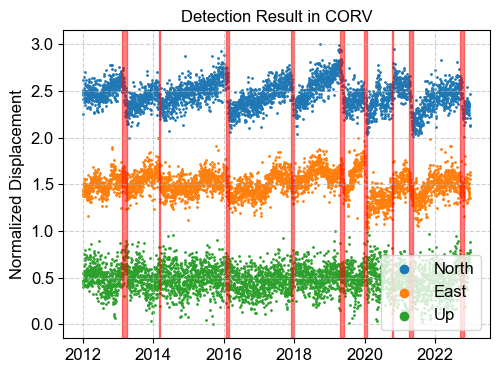

In [24]:
# test_dataset = TestDataset('/home/wj/fakenet/cascadia/Data','/home/wj/fakenet/cascadia/Data_fulltime')
from sklearn.preprocessing import MinMaxScaler
device = torch.device('cpu')
model = LSTM_attention(input_dim, hidden_dim, num_layers, output_dim)  # 定义LSTM网络
model.load_state_dict(torch.load('bilstm_attention.pth', map_location=torch.device('cpu')))

model.to(device)
model.eval()

# 创建数据加载器
datapath = 'Data1'
lakedatapath = 'Data_fulltime'
station_name = np.sort(os.listdir(datapath))
origin_data = []
origin_lack_data = []
for i in range(len(station_name)):

    tpath = os.path.join(datapath,station_name[i])
    data = pd.read_csv(tpath,header=None,sep='\t')
    datas = data.iloc[:,1:4].values
    datas= MinMaxScaler().fit_transform(datas)
    origin_data.append(datas)
    time = data.iloc[:,0].values

    lack_file_path = os.path.join(lakedatapath,station_name[i])
    lack_data = pd.read_csv(lack_file_path,header=None,sep='\t')
    lack_datas = lack_data.iloc[:,1:4].values
    origin_lack_data.append(lack_datas)

feature = torch.tensor(np.array(origin_data),dtype=torch.float32)
lack_datas= np.array(origin_lack_data)
mask =torch.tensor(~np.isnan(lack_datas))

feature = feature.to(device)
predictions = model(feature)

predictions=predictions.detach().numpy()
predictions[~mask[:,:,0]] = np.nan
predictions_class = predictions==1
# predictions = predictions.squeeze(-1)
# # print(predictions)
# predicted_classes = predictions >0.2
feature = feature.cpu()
feature[~mask] = np.nan

print('real test is done')
plt.rcParams['font.family']='Arial'

j=1
plt.figure(figsize=(5.5,4))
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.title("Detection Result in {}".format(station_name[j].upper()),fontsize=12)
plt.scatter(time,(feature[j,:,0]+2).cpu(),s=1,label='North')
plt.scatter(time,(feature[j,:,1]+1).cpu(),s=1,label='East')
plt.scatter(time,(feature[j,:,2]).cpu(),s=1,label='Up')
all_time=0
time_start = []
time_end = []
time_continued = []

in_span =False
for i,val in enumerate(predictions[j,:]):
    if val>0.99 and not in_span:
        in_span=True
        start = i
    elif val <=0.99 and in_span:
        in_span = False
        end = i
        # if end-start>12 and end-start<30:
        plt.axvspan(time[start],time[end],color='red',alpha=0.5)


plt.ylabel("Normalized Displacement",fontsize=12)
plt.legend(markerscale=6,fontsize=12,loc="lower right")
plt.grid(ls='--',alpha=0.6)
# plt.savefig('./output/bamf1.pdf',dpi=300,bbox_inches='tight')
ax = plt.gca()
plt.show()
# print(all_time)
# print(time_start)
# print(time_end)
# print(time_continued)